# Imports and Colab Mount

In [1]:
!pip install tensorflow-addons -qq

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [2]:
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
from math import sqrt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, GRU, SimpleRNN, Input, LSTM, Dense, Bidirectional, Concatenate, Reshape, Lambda, Bidirectional
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import seaborn as sns

from numpy.random import seed
#from tensorflow import set_random_seed

%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
utils.set_random_seed(42)

# Load Data

In [4]:
train_h = pd.read_csv("/content/drive/MyDrive/Datasets/solar_train.csv", index_col=0, parse_dates=True)
valid_h = pd.read_csv("/content/drive/MyDrive/Datasets/solar_valid.csv", index_col=0, parse_dates=True)
test_h = pd.read_csv("/content/drive/MyDrive/Datasets/solar_test.csv", index_col=0, parse_dates=True)
hourly = pd.read_csv("/content/drive/MyDrive/Datasets/solar_all.csv", index_col=0, parse_dates=True)

resid_train = pd.read_csv("/content/drive/MyDrive/Datasets/solar_resid_train.csv").drop("Unnamed: 0", axis=1)
resid_test = pd.read_csv("/content/drive/MyDrive/Datasets/solar_resid_test.csv").drop("Unnamed: 0", axis=1)

resid_train2 = pd.read_csv("/content/drive/MyDrive/Datasets/resid_train.csv").drop("Unnamed: 0", axis=1)
resid_test2 = pd.read_csv("/content/drive/MyDrive/Datasets/resid_test.csv").drop("Unnamed: 0", axis=1)

#sarima_pred = pd.read_csv("/content/drive/MyDrive/Datasets/solar_sarima_test.csv").drop("Unnamed: 0", axis=1)

sarima_pred = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_prediction_bad.csv").drop("Unnamed: 0", axis=1)
sarima_pred2 = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_prediction_good.csv").drop("Unnamed: 0", axis=1)

resid_series = pd.read_csv("/content/drive/MyDrive/Datasets/solar_resid_series.csv").drop("Unnamed: 0", axis=1)


In [5]:
train_h['PV Power'].to_csv("/content/drive/MyDrive/H-Transformer Shared/solar1velocidade_train.csv")
resid_series['0'][:2184].to_csv("/content/drive/MyDrive/H-Transformer Shared/solar1resid_train.csv")

In [ ]:
#hourly['PV Power'].iloc[3432:].values.shape

(588,)

In [ ]:
#np.concatenate((resid_train.values.reshape((3432,)),hourly['PV Power'].iloc[3432:].values), axis=0)

ValueError: ignored

In [ ]:
#hourly

In [ ]:
#hourly['PV Power'] = np.concatenate((resid_train.values.reshape((3432,)),hourly['PV Power'].iloc[3432:].values), axis=0)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
def make_data(data, timestep, resid_check=False):
  values = data.values
  values = values.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #scaled = scaler.fit_transform(values)
  
  timestep = timestep
  n_features = 39
  n_obs = timestep * n_features
  reframed = series_to_supervised(values, timestep, 1)
  reframed = reframed.iloc[: , :-38]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_train.values[:2184]
    valid_y = resid_train.values[2184:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  return train_X, train_y, valid_X, valid_y, test_X, test_y

In [ ]:
def make_data2(data, timestep, resid_check=False):
  values = data.values
  values = values.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #scaled = scaler.fit_transform(values)
  
  timestep = timestep
  n_features = 39
  n_obs = timestep * n_features
  reframed = series_to_supervised(values, timestep, 1)
  reframed = reframed.iloc[: , :-38]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_train.values[:2184]
    valid_y = resid_train.values[2184:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  return train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y

In [ ]:
def make_data3(df, timestep, resid_check=False, resid=False, univariate=False):

  data = df.copy()

  if resid==True:
    data['PV Power'] = resid_series.values

  if univariate==True:
    values = data["PV Power"].values
    values = values.astype('float32')
    values = values.reshape(-1, 1)

    timestep = timestep
    n_features = 1
    n_obs = timestep * n_features
    reframed = series_to_supervised(values, timestep, 1)

  else:
    values = data.values
    values = values.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled = scaler.fit_transform(values)
    
    timestep = timestep
    n_features = data.shape[1]
    n_obs = timestep * n_features
    reframed = series_to_supervised(values, timestep, 1)
    reframed = reframed.iloc[: , :1-n_features]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_series.values[timestep:(indice1)+timestep]
    valid_y = resid_series.values[(indice1)+timestep:(indice2+indice1)+timestep]
    #test_y = resid_series.values[(indice2)+timestep:]
  if (resid==True):
    test_y = df['PV Power'].values[(indice2)+timestep:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)
  return train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y

# WanDB

In [ ]:
!pip install wandb -qq
import wandb
from wandb.keras import WandbCallback
!wandb login

# Test

# RNN

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=24
layers=2
num_units=256
dropout=0.3
lr=0.001
batch_size=32

for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(SimpleRNN(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(SimpleRNN(units = num_units, dropout=dropout, return_sequences=True))

    model.add(SimpleRNN(units = num_units, dropout=dropout))

  else:
    model.add(SimpleRNN(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr*1e-3)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"RNN LIST OF RMSE: {rmse_list}")
print(f'RNN RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"RNN LIST OF MAE: {mae_list}")
print(f'RNN MAE:  {sum(mae_list)/len(mae_list)}')

print(f"RNN LIST OF MAPE: {mape_list}")
print(f'RNN MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:46<07:00, 46.75s/it]

 20%|██        | 2/10 [02:11<09:13, 69.25s/it]

 30%|███       | 3/10 [03:05<07:14, 62.03s/it]

 40%|████      | 4/10 [03:52<05:37, 56.20s/it]

 50%|█████     | 5/10 [04:42<04:30, 54.04s/it]

 60%|██████    | 6/10 [07:00<05:30, 82.61s/it]

 70%|███████   | 7/10 [08:25<04:09, 83.24s/it]

 80%|████████  | 8/10 [09:59<02:53, 86.66s/it]

 90%|█████████ | 9/10 [10:52<01:16, 76.34s/it]

100%|██████████| 10/10 [11:53<00:00, 71.37s/it]


RNN LIST OF RMSE: [1057.714913510303, 843.8178112634614, 795.910881179177, 843.881976959367, 811.9233711509092, 990.3831824818491, 797.995549711169, 1017.1543470836178, 806.3108339667766, 868.6219055873154]
RNN RMSE:  883.3714772893945
RNN LIST OF MAE: [906.249038182754, 662.6956950290106, 557.5912388117272, 646.916287716878, 592.0859132299995, 857.0007387896721, 570.9234317816231, 891.8537612542269, 585.6830148834841, 712.5296243143798]
RNN MAE:  698.3528743993757
RNN LIST OF MAPE: [0.6442679643449888, 1.4926192232008018, 0.6816290566763799, 0.2479731580940382, 0.7173048242438752, 0.5528813580524221, 1.5937256122034067, 0.6161414872875401, 0.5323384479473581, 1.0195851381510854]
RNN MAPE:  0.8098466270201896


# LSTM

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=3
layers=8
num_units=64
dropout=0.1
lr=0.01
batch_size=128

for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(LSTM(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(LSTM(units = num_units, dropout=dropout, return_sequences=True))

    model.add(LSTM(units = num_units, dropout=dropout))

  else:
    model.add(LSTM(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr*1e-4)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"LSTM LIST OF RMSE: {rmse_list}")
print(f'LSTM RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"LSTM LIST OF MAE: {mae_list}")
print(f'LSTM MAE:  {sum(mae_list)/len(mae_list)}')

print(f"LSTM LIST OF MAPE: {mape_list}")
print(f'LSTM MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:37<05:35, 37.23s/it]

 20%|██        | 2/10 [01:37<06:47, 50.92s/it]

 30%|███       | 3/10 [02:11<05:02, 43.16s/it]

 40%|████      | 4/10 [02:52<04:12, 42.14s/it]

 50%|█████     | 5/10 [04:02<04:21, 52.29s/it]

 60%|██████    | 6/10 [04:41<03:11, 47.83s/it]

 70%|███████   | 7/10 [05:42<02:36, 52.06s/it]

 80%|████████  | 8/10 [06:36<01:45, 52.78s/it]

 90%|█████████ | 9/10 [08:18<01:08, 68.01s/it]

100%|██████████| 10/10 [08:51<00:00, 53.13s/it]


LSTM LIST OF RMSE: [893.1167326503207, 823.013852305582, 858.6782695687788, 827.6337479044192, 852.2329171985182, 822.2305577460575, 822.57292001685, 893.9159983275771, 878.2709260921827, 830.376635292782]
LSTM RMSE:  850.2042557103068
LSTM LIST OF MAE: [621.4625315721631, 605.8177249265359, 597.7719598286039, 586.8008441379089, 592.8267177539124, 596.6333991844742, 603.2806180437965, 627.2798847302696, 609.9370417909842, 586.1924278194047]
LSTM MAE:  602.8003149788053
LSTM LIST OF MAPE: [0.24636890392280258, 0.48417514892486524, 0.2382862553338905, 0.264054971804746, 0.22993323239055113, 0.5987400946816621, 0.4389610597696535, 0.2522655700813515, 0.2572883646698058, 0.275756412062273]
LSTM MAPE:  0.3285830013641602


# GRU

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=12
layers=1
num_units=256
dropout=0.3
lr=0.01
batch_size=128

for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(GRU(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(GRU(units = num_units, dropout=dropout, return_sequences=True))

    model.add(GRU(units = num_units, dropout=dropout))

  else:
    model.add(GRU(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"GRU LIST OF RMSE: {rmse_list}")
print(f'GRU RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"GRU LIST OF MAE: {mae_list}")
print(f'GRU MAE:  {sum(mae_list)/len(mae_list)}')

print(f"GRU LIST OF MAPE: {mape_list}")
print(f'GRU MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:42<06:25, 42.86s/it]

 20%|██        | 2/10 [01:31<06:10, 46.28s/it]

 30%|███       | 3/10 [02:57<07:29, 64.28s/it]

 40%|████      | 4/10 [04:08<06:42, 67.00s/it]

 50%|█████     | 5/10 [05:05<05:16, 63.38s/it]

 60%|██████    | 6/10 [05:49<03:47, 56.76s/it]

 70%|███████   | 7/10 [06:12<02:17, 45.80s/it]

 80%|████████  | 8/10 [07:00<01:33, 46.55s/it]

 90%|█████████ | 9/10 [07:44<00:45, 45.84s/it]

100%|██████████| 10/10 [08:31<00:00, 51.19s/it]


GRU LIST OF RMSE: [861.6943387558028, 879.9810725712497, 879.0332024751648, 864.78987704048, 853.4020062396511, 830.2931357826789, 1071.0287161414815, 879.750494158599, 841.6869967997569, 842.2190224941442]
GRU RMSE:  880.3878862459009
GRU LIST OF MAE: [615.8404422659374, 598.9518870122528, 611.7535910789621, 586.5551911002422, 596.2369911152191, 595.5919584058257, 804.5490140569257, 605.6931661879017, 605.8129401738511, 590.6379157971389]
GRU MAE:  621.1623097194257
GRU LIST OF MAPE: [0.46386539240107794, 0.2684207542626551, 0.2941655209721515, 0.6982261309519322, 0.29459403877746543, 0.5587729127247925, 0.29245587671970585, 1.7756622559273776, 1.7099560902719364, 0.45040227098072905]
GRU MAPE:  0.6806521243989824


# Transformer

In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.feat_dim = feat_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):

        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'feat_dim': self.feat_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

In [ ]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

    def get_config(self):

        config = super().get_config()
        config.update({
            'kernel_size': self.k,
        })
        return config

In [ ]:
EPOCHS = 50
N_HEADS = 8
N_FOLDS = 10
FF_DIM = 256
N_BLOCKS = 6
EMBED_DIM = 64
BATCH_SIZE = 16
WINDOW_SIZE = 65
DROPUT_RATE = 0.0
TIME_2_VEC_DIM = 3
TRAIN_MODEL = True
SKIP_CONNECTION_STRENGTH = 0.9

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

batch_size=32
lr=0.001
N_HEADS = 2
FF_DIM = 256
N_BLOCKS = 8
EMBED_DIM = 32
DROPUT_RATE = 0.3
time2vec_dim = 4
timestep = 6

for z in tqdm(range(1)):
  utils.set_random_seed(8)
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data3(hourly, timestep, resid_check=True, resid=False, univariate=False)


  input_shape = train_X.shape[1:]
  inp = Input(input_shape)
  x = inp

  time_embedding = keras.layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
  x = Concatenate(axis = -1)([x, time_embedding])
  x = layers.LayerNormalization(epsilon = 1e-6)(x)

  for k in range(N_BLOCKS):
    x_old = x
    transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1] + ( input_shape[-1] * time2vec_dim), N_HEADS, FF_DIM, DROPUT_RATE)
    x = transformer_block(x)
    x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)

  x = layers.Flatten()(x)

  x = layers.Dense(128, activation = "selu")(x)
  x = layers.Dropout(DROPUT_RATE)(x)
  x = Dense(1, activation = 'linear')(x)

  out = x
  model = Model(inp, out)

#   radam = tfa.optimizers.RectifiedAdam(
#     lr=1e-3,
#     total_steps=10000,
#     warmup_proportion=0.1,
#     min_lr=1e-6,
# )

#   ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)


  model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr)
              )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=1, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=20, restore_best_weights=True)]
          )
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred2.values[timestep:]).clip(min=0)

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"Transformer LIST OF RMSE: {rmse_list}")
print(f'Transformer RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"Transformer LIST OF MAE: {mae_list}")
print(f'Transformer MAE:  {sum(mae_list)/len(mae_list)}')

print(f"Transformer LIST OF MAPE: {mape_list}")
print(f'Transformer MAPE:  {sum(mape_list)/len(mape_list)}')

  0%|          | 0/1 [00:00<?, ?it/s]

(2184, 6, 39) (2184, 1) (1248, 6, 39) (1248, 1) (582, 6, 39) (582, 1)
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 59s 141ms/step - loss: 2.7599 - val_loss: 2.2425
Epoch 2/200
69/69 [==============================] - 9s 125ms/step - loss: 1.4957 - val_loss: 5.5059
Epoch 3/200
69/69 [==============================] - 9s 126ms/step - loss: 1.2573 - val_loss: 4.8870
Epoch 4/200
69/69 [==============================] - 9s 126ms/step - loss: 1.1631 - val_loss: 3.7606
Epoch 5/200
69/69 [==============================] - 9s 128ms/step - loss: 0.9713 - val_loss: 1.6873
Epoch 6/200
69/69 [==============================] - 9s 128ms/step - loss: 0.8849 - val_loss: 1.3916
Epoch 7/200
69/69 [==============================] - 9s 129ms/step - loss: 0.6745 - val_loss: 0.7025
Epoch 8/200
69/69 [==============================] - 9s 127ms/step - loss: 0.6110 - val_loss: 0.4586
Epoch 9/200
69/69 [==============================] - 9s 126ms/step - loss: 0.5263 - val_loss: 0.5614
Epoch 10/200
69/69 [==============================] - 9s 126ms/step - loss: 0.4405 - val_loss: 0.3109


100%|██████████| 1/1 [22:13<00:00, 1333.84s/it]


Transformer LIST OF RMSE: [779.8922418389568]
Transformer RMSE:  779.8922418389568
Transformer LIST OF MAE: [517.3279321995834]
Transformer MAE:  517.3279321995834
Transformer LIST OF MAPE: [1.4835283376420716e+16]
Transformer MAPE:  1.4835283376420716e+16


In [ ]:
pd.Series(resid_sum[:,0]).to_csv("/content/drive/MyDrive/Hybrid Transformer/Results/df1.csv")
pd.Series(scaler_y.inverse_transform(test_y)[:,0]).to_csv("/content/drive/MyDrive/Hybrid Transformer/Results/df1_test.csv")
#scaler_y.inverse_transform(test_y)

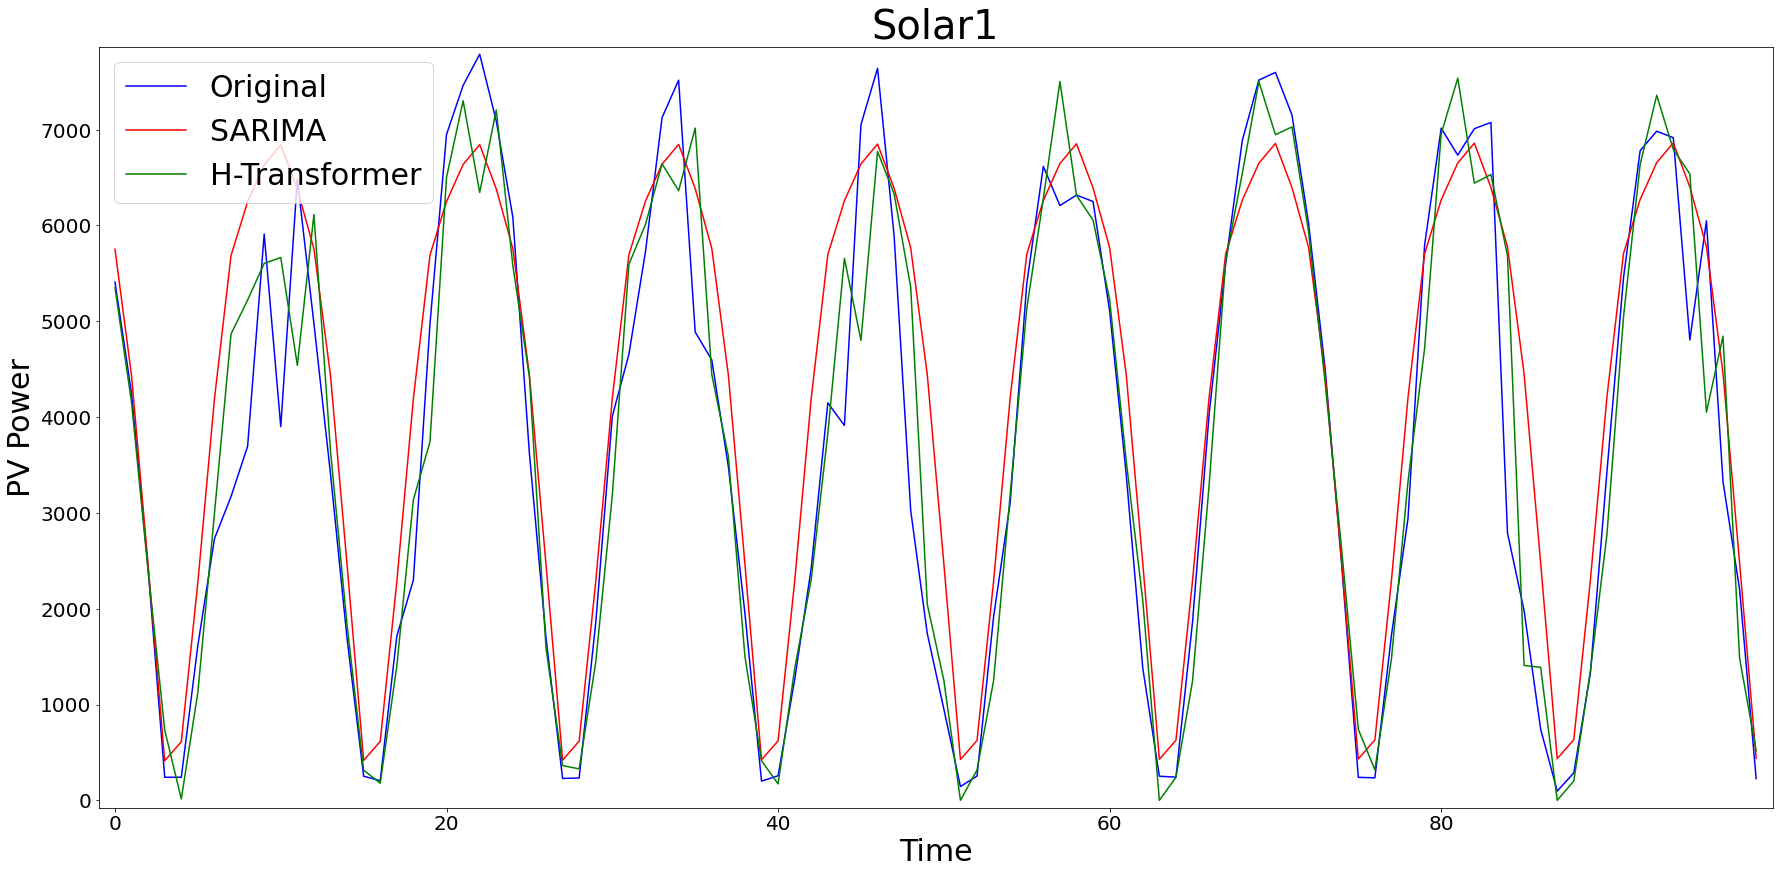

In [ ]:
size = range(sarima_pred.values[-100:].shape[0])
plt.figure(figsize=(30, 14))
plt.plot(size, scaler_y.inverse_transform(test_y)[-100:], 'b', label='Original')
plt.plot(size, sarima_pred.values[-100:], 'r', label='SARIMA')
plt.plot(size, (resid_sum.clip(min=0)[-100:]), 'g', label='H-Transformer')


plt.title("Solar1", fontdict = {'fontsize' : 40})
plt.legend(fontsize=30, loc='upper left')
plt.ylabel('PV Power', fontdict = {'fontsize' : 30})
plt.xlabel('Time', fontdict = {'fontsize' : 30})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.margins(x=0.01, y=0.01)


plt.show()